# Multivariate Regression Analysis Of UK GDP growth

In this notebook a multiple regression analysis will be performed to determine the main economic indicators which affect the life expectancy of citizens. The data was attained the world bank website from 1971 as there were missing prior to this date.

## Tl;dr

The resulting $R^2$ value of the model is 0.881

The only significant variable in determining the UK's GDP growth is the Households and NPISHs Final consumption expenditure growth where a 1 % increase in this variable leads to a 0.837 % increase in GDP growth. 


## Assumptions of the Model

Prior to performing the multivariate reggression analysis it is essential to state the assumptions of the model. If any of the assumptions are violated it means that extra steps may have to take extra steps to improve our model or in some cases dump the model altogether. Here is a list of the assumptions of the model:

- Regression residuals must be normally distributed.
- A linear relationship is assumed between the dependent variable and the independent variables.
- The residuals are homoscedastic and approximately rectangular-shaped.i.e Errors should be constant
- Absence of multicollinearity is expected in the model, meaning that independent variables are not too highly correlated.
- No Autocorrelation of the residuals.

# Step 1: Import Libraries

In [1]:
#Import common libraries
import numpy as np
import pandas as pd
from scipy import stats

#Import data visualiastion libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries to determine issues with the data
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Import Libraries for multiple linear regression and analysis of the results
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from pprint import pprint
import pylab
#Inline graphs within the jupyter notebook
%matplotlib inline

# Step 2: Load the U.K economic data and perform data cleansing

The data was attained through the World Bank's webiste (see https://databank.worldbank.org/source/world-development-indicators# for more information)

In [2]:
econ_df = pd.read_csv('uk_data.csv')
econ_df

,Unnamed: 0,Country Name,Country Code,Series Name,Series Code,1971 [YR1971],1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],...,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019]
0,0,United Kingdom,GBR,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,3.300000e+00,3.700000e+00,2.600000e+00,2.600000e+00,4.000000e+00,...,7.786600e+00,8.037700e+00,7.884600e+00,7.524200e+00,6.109600e+00,5.300300e+00,4.809700e+00,4.330000e+00,3.995900e+00,3.737200e+00
1,1,United Kingdom,GBR,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,3.504718e+00,4.321668e+00,6.523848e+00,-2.484404e+00,-1.473650e+00,...,1.949521e+00,1.540147e+00,1.478924e+00,2.139486e+00,2.607476e+00,2.355524e+00,1.918155e+00,1.892077e+00,1.340721e+00,1.462658e+00
2,3,United Kingdom,GBR,Population growth (annual %),SP.POP.GROW,4.176666e-01,3.390575e-01,1.931982e-01,6.305921e-02,-7.423363e-03,...,7.838886e-01,7.815066e-01,6.953531e-01,6.697405e-01,7.364640e-01,7.923675e-01,7.578745e-01,6.793745e-01,6.059291e-01,5.612554e-01
3,4,United Kingdom,GBR,Broad money (% of GDP),FM.LBL.BMNY.GD.ZS,3.338482e+01,3.818585e+01,4.216989e+01,4.244469e+01,3.669766e+01,...,1.641232e+02,1.514039e+02,1.478885e+02,1.450844e+02,1.353428e+02,1.340597e+02,1.400059e+02,1.460452e+02,1.485760e+02,1.417789e+02
4,5,United Kingdom,GBR,Final consumption expenditure (% of GDP),NE.CON.TOTL.ZS,8.459326e+01,8.580772e+01,8.503250e+01,8.898159e+01,9.099049e+01,...,8.590778e+01,8.524862e+01,8.533312e+01,8.497606e+01,8.428412e+01,8.396689e+01,8.421903e+01,8.367812e+01,8.395419e+01,8.365008e+01
5,6,United Kingdom,GBR,Gross capital formation (current US$),NE.GDI.TOTL.CD,3.495945e+10,3.906731e+10,5.190317e+10,5.668858e+10,5.737516e+10,...,3.982296e+11,4.163467e+11,4.284279e+11,4.541377e+11,5.242216e+11,5.099661e+11,4.688251e+11,4.672468e+11,4.919451e+11,4.899565e+11
6,7,United Kingdom,GBR,Gross domestic savings (% of GDP),NY.GDS.TOTL.ZS,1.540674e+01,1.419228e+01,1.496750e+01,1.101841e+01,9.009508e+00,...,1.409222e+01,1.475138e+01,1.466688e+01,1.502394e+01,1.571588e+01,1.603311e+01,1.578097e+01,1.632188e+01,1.604581e+01,1.634992e+01
7,8,United Kingdom,GBR,General government final consumption expenditu...,NE.CON.GOVT.CD,2.686133e+10,3.143298e+10,3.525287e+10,4.164901e+10,5.436917e+10,...,5.361018e+11,5.576354e+11,5.620073e+11,5.606598e+11,6.075383e+11,5.708923e+11,5.151286e+11,4.976393e+11,5.286015e+11,5.329537e+11
8,9,United Kingdom,GBR,Households and NPISHs Final consumption expend...,NE.CON.PRVT.KD.ZG,3.186127e+00,6.361071e+00,5.537878e+00,-1.623357e+00,-1.333560e-01,...,1.247482e+00,-7.540189e-03,1.597316e+00,2.682505e+00,2.289761e+00,2.985330e+00,3.646308e+00,2.210306e+00,1.580326e+00,9.732737e-01
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The rows 9 and below need to be dropped as they are invalid, furthermore the Country Name, Series Code Country Code  columns need to be dropped as it is already known that the uk is the country of interest and the other fields mentioned are obsolete.

In [3]:

#Dropping irrelevant columns
econ_df = econ_df.dropna(axis=0).drop(columns=['Country Name','Series Code','Country Code'])
# TRanspose dataframe in order to get years as the index and variables as the column
econ_df = econ_df.transpose()

econ_df.columns = econ_df.loc['Series Name'] # Column names are under the column series name
econ_df = econ_df.drop(['Series Name'], axis=0) # Remove column as data is now saved
econ_df.columns.name = None # Remove text from the corner

# This is to enable mathematical operations to be performed
econ_df = econ_df.astype('float64')

econ_df.head()

,"Unemployment, total (% of total labor force) (national estimate)",GDP growth (annual %),Population growth (annual %),Broad money (% of GDP),Final consumption expenditure (% of GDP),Gross capital formation (current US$),Gross domestic savings (% of GDP),General government final consumption expenditure (current US$),Households and NPISHs Final consumption expenditure (annual % growth)
Unnamed: 0,0.0,1.000000,3.000000,4.000000,5.000000,6.000000e+00,7.000000,8.000000e+00,9.000000
1971 [YR1971],3.3,3.504718,0.417667,33.384818,84.593257,3.495945e+10,15.406743,2.686133e+10,3.186127
1972 [YR1972],3.7,4.321668,0.339058,38.185852,85.807722,3.906731e+10,14.192278,3.143298e+10,6.361071
1973 [YR1973],2.6,6.523848,0.193198,42.169886,85.032499,5.190317e+10,14.967501,3.525287e+10,5.537878
1974 [YR1974],2.6,-2.484404,0.063059,42.444689,88.981588,5.668858e+10,11.018412,4.164901e+10,-1.623357


In [4]:
# Remove newly created unnamed row
econ_df = econ_df.drop(['Unnamed: 0'],axis=0)

In [5]:
econ_df.index = [i for i in range(1971,2020)]
econ_df.head()

,"Unemployment, total (% of total labor force) (national estimate)",GDP growth (annual %),Population growth (annual %),Broad money (% of GDP),Final consumption expenditure (% of GDP),Gross capital formation (current US$),Gross domestic savings (% of GDP),General government final consumption expenditure (current US$),Households and NPISHs Final consumption expenditure (annual % growth)
1971,3.3,3.504718,0.417667,33.384818,84.593257,3.495945e+10,15.406743,2.686133e+10,3.186127
1972,3.7,4.321668,0.339058,38.185852,85.807722,3.906731e+10,14.192278,3.143298e+10,6.361071
1973,2.6,6.523848,0.193198,42.169886,85.032499,5.190317e+10,14.967501,3.525287e+10,5.537878
1974,2.6,-2.484404,0.063059,42.444689,88.981588,5.668858e+10,11.018412,4.164901e+10,-1.623357
1975,4.0,-1.473650,-0.007423,36.697659,90.990492,5.737516e+10,9.009508,5.436917e+10,-0.133356


In [6]:
for i in econ_df.columns:
    print('\''+i+'\'')

'Unemployment, total (% of total labor force) (national estimate)'
'GDP growth (annual %)'
'Population growth (annual %)'
'Broad money (% of GDP)'
'Final consumption expenditure (% of GDP)'
'Gross capital formation (current US$)'
'Gross domestic savings (% of GDP)'
'General government final consumption expenditure (current US$)'
'Households and NPISHs Final consumption expenditure (annual % growth)'


In [7]:
column_new = {
    'Unemployment, total (% of total labor force) (national estimate)':'unemployment',
    'GDP growth (annual %)':'gdp_growth',
    'Population growth (annual %)':'pop_growth',
    'Broad money (% of GDP)':'broad_money',
    'Final consumption expenditure (% of GDP)':'final_cons',
    'Gross capital formation (current US$)':'gross_cap_cons',
    'Gross domestic savings (% of GDP)':'gross_saving',
    'General government final consumption expenditure (current US$)':'gov_expend',
    'Households and NPISHs Final consumption expenditure (annual % growth)':'hh_expend'
}


econ_df = econ_df.rename(columns=column_new)
econ_df.head()

,unemployment,gdp_growth,pop_growth,broad_money,final_cons,gross_cap_cons,gross_saving,gov_expend,hh_expend
1971,3.3,3.504718,0.417667,33.384818,84.593257,3.495945e+10,15.406743,2.686133e+10,3.186127
1972,3.7,4.321668,0.339058,38.185852,85.807722,3.906731e+10,14.192278,3.143298e+10,6.361071
1973,2.6,6.523848,0.193198,42.169886,85.032499,5.190317e+10,14.967501,3.525287e+10,5.537878
1974,2.6,-2.484404,0.063059,42.444689,88.981588,5.668858e+10,11.018412,4.164901e+10,-1.623357
1975,4.0,-1.473650,-0.007423,36.697659,90.990492,5.737516e+10,9.009508,5.436917e+10,-0.133356


In [8]:
#Check for null values
econ_df.isnull().any()

unemployment      False
gdp_growth        False
pop_growth        False
broad_money       False
final_cons        False
gross_cap_cons    False
gross_saving      False
gov_expend        False
hh_expend         False
dtype: bool

# Step 3: Preliminary analysis of the data

In [9]:
econ_df.describe()

,unemployment,gdp_growth,pop_growth,broad_money,final_cons,gross_cap_cons,gross_saving,gov_expend,hh_expend
count,49.000000,49.000000,49.000000,49.000000,49.000000,4.900000e+01,49.000000,4.900000e+01,49.000000
mean,6.801243,2.237760,0.373261,85.629456,85.352898,2.702665e+11,14.647102,2.867589e+11,2.573820
std,2.522057,2.073977,0.268195,45.113356,2.070570,1.633121e+11,2.070570,1.991567e+11,2.253070
min,2.600000,-4.247822,-0.035843,30.453995,81.078209,3.495945e+10,9.009508,2.686133e+10,-2.736649
25%,4.809700,1.540147,0.212637,38.185852,83.966892,1.067343e+11,13.340782,1.116148e+11,1.092025
50%,6.109600,2.489831,0.298931,82.067269,85.248623,2.510424e+11,14.751377,2.353995e+11,2.682505
75%,8.552100,3.437472,0.669741,134.059699,86.659218,4.262798e+11,16.033108,5.151286e+11,4.196410
max,11.510500,6.523848,0.792368,164.123174,90.990492,5.751100e+11,18.921791,6.091457e+11,7.757053


A key thing to mention about the data is that there are only 49 observations and given the heuristic that there should be at least 20 observations per variable. However in the end there is only 1 variable which results in the heiristic being satisfied.

By looking at the data above there appears to be no outliers as the maximum and minimum valuea for each variable is within 3 standard deviations. This means that outlier do not need to be filtered out. 

However outliers would not be removed even if they are present. This is because the outliers would represent real data points where the economy is undergoing a recession or is booming.

# Step 4: Check for perfect multicollinearity

## Testing for Heteroscedasticity

### What is multicollinearity?

 Multicollinearity is when variables within the dataset are highly correlated to other variables within the dataset. 

### Why is multicollinearity bad?

The main issue withmulticollineaity is that variables effectively double counting two variables which are indistinguishable from one another. This leads to the estimation of the coefficients to be unreliable and the errors of the slope coefficents to be aertificially inflated.

## Methodology for testing for Hetreoscedasticity

The first thing to do is to produce a heatmap of the correlations using the `corr` function (this will create a matrix of the correlations). Values close to 1 and -1 will imply strong correlations.

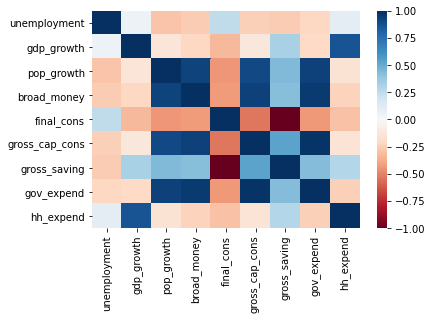

In [10]:
# Produce a matrix of correlations
corr_matrix = econ_df.corr()

# plot the correlation heatmap
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='RdBu')

From the above heatmap it can be seen that there are some strong correlations

Therefore further analysis wil be used. The variance inflation factor (VFI) will thereofre be calculated. 
As a rule of thumb, if the VFI is higher than 5 for a variable then that variable should be removed

In [11]:
econ_df_original = econ_df

#the VFI expects a constant so the add_constant method will be used
X1 = sm.tools.add_constant(econ_df_original)

series_original = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)
series_original

/home/shadowman/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const             0.000000e+00
unemployment      1.305188e+00
gdp_growth        4.085994e+00
pop_growth        1.159724e+01
broad_money       1.486426e+01
final_cons        5.762800e+10
gross_cap_cons    4.206559e+01
gross_saving      4.242675e+11
gov_expend        6.784909e+01
hh_expend         4.626958e+00
dtype: float64

The `gross_saving', final_cons, gross_cap_cons, gov_expend`and household expenditure are all well above the VFI of 5 so therefore they be removed. The `broad_money, pop_growth` will remain for now as they aren't that far away from 5 and may become lower than 5 as a result of removing the other variables

In [12]:
X2 = sm.tools.add_constant(econ_df_original.drop(columns=['gross_saving','final_cons','gross_cap_cons','gov_expend']))

series_2 = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index=X2.columns)
series_2

const           18.855656
unemployment     1.102633
gdp_growth       3.918731
pop_growth       7.812934
broad_money      7.920496
hh_expend        4.039014
dtype: float64

The `broad_money, pop_growth` are still above 5 so they are better off being removed as well.

In [13]:
X3 = X2.drop(columns=['broad_money','pop_growth'])

series_3 = pd.Series([variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])], index=X3.columns)
series_3

const           9.322005
unemployment    1.015624
gdp_growth      3.916221
hh_expend       3.946907
dtype: float64

In [14]:
econ_df.describe()

,unemployment,gdp_growth,pop_growth,broad_money,final_cons,gross_cap_cons,gross_saving,gov_expend,hh_expend
count,49.000000,49.000000,49.000000,49.000000,49.000000,4.900000e+01,49.000000,4.900000e+01,49.000000
mean,6.801243,2.237760,0.373261,85.629456,85.352898,2.702665e+11,14.647102,2.867589e+11,2.573820
std,2.522057,2.073977,0.268195,45.113356,2.070570,1.633121e+11,2.070570,1.991567e+11,2.253070
min,2.600000,-4.247822,-0.035843,30.453995,81.078209,3.495945e+10,9.009508,2.686133e+10,-2.736649
25%,4.809700,1.540147,0.212637,38.185852,83.966892,1.067343e+11,13.340782,1.116148e+11,1.092025
50%,6.109600,2.489831,0.298931,82.067269,85.248623,2.510424e+11,14.751377,2.353995e+11,2.682505
75%,8.552100,3.437472,0.669741,134.059699,86.659218,4.262798e+11,16.033108,5.151286e+11,4.196410
max,11.510500,6.523848,0.792368,164.123174,90.990492,5.751100e+11,18.921791,6.091457e+11,7.757053


# Step 5:Bulding the model

In [15]:
regress_cols = list(set(X3) & set(econ_df))

In [16]:
econ_df_after = econ_df[regress_cols]

X =  econ_df_after.drop('gdp_growth', axis = 1)
Y = econ_df_after[['gdp_growth']]


In [17]:
X_r = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X_r)

# fit the data
est = model.fit()

In [18]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gdp_growth   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     67.07
Date:                Wed, 30 Dec 2020   Prob (F-statistic):           2.31e-14
Time:                        22:37:55   Log-Likelihood:                -71.321
No. Observations:                  49   AIC:                             148.6
Df Residuals:                      46   BIC:                             154.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3785      0.464      0.816      0.418      -0.555       1.312
unemployment    -0.0282      0.062     -0.459      0.649      -0.152       0.096
hh_expend        0.7970      0.069     11.558      0.000       0.658       0.936
==============================================================================
Omnibus:                        0.376   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.036
Skew:                           0.035   Prob(JB):                        0.982
Kurtosis:                       3.113   Cond. No.                         23.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Step 6: Testing for Heteroscedasticity

### What is Heteroscedasticity?

One of the aforementioned assumptions is that there's no heteroscedasticity. Heteroscedasticity means that the standard errors of a variable, monitored over a specific amount of time, are non-constant.

### Why is heteroscedasticity bad?

The two main reasons why heteroscedasticity is bad are:

1. Heteroscedasticity **causes the coefficient estimates to become less precise.** The lower precision then increases the likelihood that the coefficients determined from the linear regression are further from the correct value.

2. **Heteroscedasticity tends to produce p-values that are smaller than they should be.** This is because hetroscedasticity increases the variance of the coefficent estimates but Ordinary Last Squares (OLS) doesn't register this increase. As a result OLS caluclates the t-values as F-values that underestimate he variance. This can cause you to conclude a variable in the model is statistically significant when it is not.

## Methodology for testing for Hetreoscedasticity

The `statsmodels.stats.diagnostic` module will be used to test for heteroscedasticity. The Breusch-Pagan test will be used.

* **H0 = σ2i = σ2**: The null hypothesis for both the White's test and the Breusch-Pagan test is that the variance for the errors are constant.

* **H1 = σ2i ≠ σ2**: The alternate hypothesis is that the variance is not equal.

The desired outcome is to fail to reject the null hypothesis and have a high p-value because this will imply no heteroscedasticity.

In [19]:
# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print('The p-value is:',pval,'and the f-value is:', f_pval)
print('='*100)

# print the results of the test
if pval > 0.075:
    print('-'*25,"Breusch-Pagan's Test")
    print("The p-value is:", pval)
    print("The null hypthoesis is aceepted therefore there is heterosecdasticity. \n")

else:
    print('-'*25,"Breusch-Pagan's Test")
    print("The p-value is:",pval)
    print("The null hypthoesis is rejected therefore there is no heterosecdasticity. \n")

The p-value is: 0.06573464581946034 and the f-value is: 0.06660926919659385
------------------------- Breusch-Pagan's Test
The p-value is: 0.06573464581946034
The null hypthoesis is rejected therefore there is no heterosecdasticity. 



The p-value is close enough to 0.05 that heteroscedasticity to be assumed negligible

# Step 6: Testing for Autocorrelation

## Why test for autocorrelation?

If autocorrelation exists, then this means that the standard errors and the determined p-values will be misleading. Autocorrelation is also a sign that a model may be defective.

## Methodology for testing for autocorrelation

The `statsmodels.stats.diagnostic` module and the Ljung-Box test will be used to test for no autocorrelation of the residuals. The hypotheses are the following:

* H0: The data are random (therefore no autocorrelation)
* H1: The data is not random (therefore there is autocorrelation)

The desired outcome is to fail to reject the null hypothesis. This means a large p-value is desired. To use the Ljung-Box test the `acorr_ljungbox` function from `statsmodels.stats.diagnostic` will be used and the residuals will be passed as an argument along with the lags.

The lags will be calculated using a rule of thumb for non-seasonal time series which states that the lag is ` min(10, (num_obs // 5))`.

Finally the autocorrelation test will be visually shown using the `statsmodels.graphics` module to plot a graph of the autocorrelation factor.

The lowest p-value is: 0.08709966455006742
Therefore we fail to reject the null hypthoesis and there is no autocorrelation.


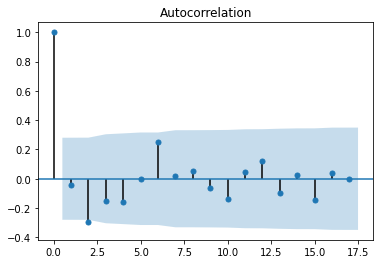

In [20]:
#Calculate lags to silence warning in acorr_ljungbox
lag = min(10, (len(X)//5))

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid,lags=lag,return_df=False)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value is:",min(p_val))
    print("Therefore we fail to reject the null hypthoesis and there is no autocorrelation.")
    print('='*50)
else:
    print("The lowest p-value is", min(p_val))
    print("Therefore we reject the null hypthoesis and there is autocorrelation.")
    print('='*50)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

# Step 7: Determining the mean of the Residuals is 0

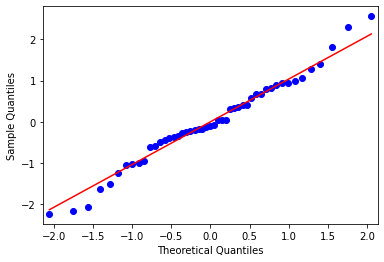

The mean of the residuals is: -8.519262393042017e-16


In [21]:
# Visualise the normality of the residuals
sm.qqplot(est.resid,line='s')
pylab.show()

#Determine that the mean residual is approximately 0
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is:",mean_residuals)

# Step 8: Determining statistically insignificant parameters

In [22]:
est.pvalues

const           4.184625e-01
unemployment    6.487443e-01
hh_expend       3.348118e-15
dtype: float64

### Removing irrelevant parameters

From the pvalues it can be seen that both unemployment and the constant are statistically insignificant values. This is because the pvalues are well above 0.05. Subsequently another model will be produced with only the household consumption as the main parameter.

In [23]:
X_new =  econ_df[['hh_expend']]
Y_new = econ_df_after[['gdp_growth']]

model_2 = sm.OLS(Y_new,X_new)
est_2 = model_2.fit()

In [24]:
est_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             gdp_growth   R-squared (uncentered):                   0.881
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              355.4
Date:                Wed, 30 Dec 2020   Prob (F-statistic):                    7.88e-24
Time:                        22:37:55   Log-Likelihood:                         -71.799
No. Observations:                  49   AIC:                                      145.6
Df Residuals:                      48   BIC:                                      147.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hh_expend      0.8370      0.044     18.853      0.000       0.748       0.926
==============================================================================
Omnibus:                        0.903   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.319
Skew:                           0.140   Prob(JB):                        0.853
Kurtosis:                       3.278   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion

Overall a model has been produced which satisfies all the assumptions of:

* Regression residuals must be normally distributed.
* A linear relationship is assumed between the dependent variable and the independent variables.
* The residuals are homoscedastic and approximately rectangular-shaped.i.e Errors should be constant
* Absence of multicollinearity is expected in the model, meaning that independent variables are not too highly correlated.
* No Autocorrelation of the residuals.

The resulting model produced (after removing statistically insignificant variables) was robust and had an adjusted $R^2$ of 0.879. 

The result of dropping these parameters are an even more robust model. Therefore it can be concluded that the most significant parameter for predicting the GDP of the UK is the growth in household consumption.